# Low-thrust transfers via indirect methods II (time)

In this notebook we show how to solve the minimum time Optimal Control Problem (OCP) for a fixed time low-thrust interplanetary transfer employing an indirect method.

Indirect methods are basically following the same template: starting from the dynamics an augmented system of ODE is built applying Pontryagin maximum (minimum, in our case) principle. A Two Point Boundary Value Problem is hence defined on the derived augmented system and solved by means of single or multiple shooting.

In this notebook we guide, step-by-step, the reader in the application of such a method in a widely encountered case in space flight mechanics, and eventually use `pykep` native tools to quickly skip the tedious parts.

We highlight the differences with respect to the developments presented in the [mass optimal](<./pontryagin_cartesian.ipynb>) version of the very same indirect method.

In [1]:
import pykep as pk
import numpy as np
import heyoka as hy
import pygmo as pg
import pygmo_plugins_nonfree as ppnf

from matplotlib import pyplot as plt

## Manual construction of the TPBVP
We consider the dynamics:

$$
\left\{
\begin{array}{l}
\dot{\mathbf r}  = \mathbf v \\
\dot{\mathbf v} = -\frac{mu}{r^3}\mathbf r + c_1 \frac um \hat{\mathbf i}\\
\dot{m} = - c_2 u
\end{array}
\right.
$$
where $c_1=T_{max}$ is the maximum thrust that the spacecarft propulsion can deliver, while $c_2 = \frac{T_{max}}{I_{sp} g_0}$.

We also introduce as many auxiliary functions $\mathbf \lambda$ (the co-states) are there are state variables. Using `heyoka` as a symbolic manipulator, let us introduce symbols for all the time dependent quantities:

In [2]:
# The state
x, y, z, vx, vy, vz, m = hy.make_vars("x", "y", "z", "vx", "vy", "vz", "m")
# The costate
lx, ly, lz, lvx, lvy, lvz, lm = hy.make_vars(
    "lx", "ly", "lz", "lvx", "lvy", "lvz", "lm"
)
# The controls
u, ix, iy, iz = hy.make_vars("u", "ix", "iy", "iz")

As to write comfortably the various developments, we introduce some useful expressions and regroup some of our variable into 3D vectors.

In [3]:
# Useful expressions
r3 = (x**2 + y**2 + z**2) ** (1.5)
lv_norm = hy.sqrt(lvx**2 + lvy**2 + lvz**2)

# Vectors for convenience of math manipulation
lr = np.array([lx, ly, lz])
lv = np.array([lvx, lvy, lvz])
r = np.array([x, y, z])
v = np.array([vx, vy, vz])
i_vers = np.array([ix, iy, iz])

For consistency to the mass optimal case we keep the space for an $\epsilon$ parameter (index 3) but we will not use it here since the optimality principle is simply:

$$
J = \int_0^T dt
$$

and results already in a smooth trajectory (no need to introduce a continuation parameter). 

Note how the various constants of our problem are thus considered as heyoka parameters in the following order: $[\mu, c_1, c_2, \epsilon, \lambda_0]$, $c_1 = T_{max}$, $c_2 = \frac{T_{max}}{I_{sp}g_0}$

The dynamics can then be written as:

In [4]:
# Dynamics
fr = v
fv = hy.par[1] * u / m * i_vers - (hy.par[0] / r3) * r
fm = -hy.par[2] * u

We introduce the Hamiltonian ($\mathbf x$ is the whole state, $\mathbf \lambda$ is the whole co-state, and $\mathbf u$ represent are all the controls), 

$$
\mathcal H(\mathbf x, \mathbf \lambda, \mathbf u) = \mathbf \lambda_r \cdot \mathbf f_r + \mathbf \lambda_v \cdot \mathbf f_v + \lambda_m  f_m + \lambda_0
$$



In [5]:
# Hamiltonian
H_full = lr @ fr + lv @ fv + lm * fm + hy.par[4]

And write the resulting Hamiltonian system:

$$
\left\{
\begin{array}{l}
\dot{\mathbf x} = \frac{\partial \mathcal H}{\partial \mathbf \lambda} \\
\dot{\mathbf \lambda} = - \frac{\partial \mathcal H}{\partial \mathbf x} \\
\end{array}\right.
$$

In [6]:
# Augmented equations of motion
rhs = [
    hy.diff(H_full, var)
    for var in [lx, ly, lz, lvx, lvy, lvz, lm, x, y, z, vx, vy, vz, m]
]
for j in range(7, 14):
    rhs[j] = -rhs[j]

The minimum principle from Pontryagin requires to find the mimimum in the admissible control space of the Hamiltonian:

$$
\mathbf u^* = \argmin_{\mathbf u \in \mathcal U} \mathcal H(\mathbf x, \mathbf \lambda, \mathbf u)
$$

which, in our case, results in:

In [8]:
# We apply Pontryagin minimum principle (primer vector and u^* = 1.)
argmin_H_full = {
    ix: -lvx / lv_norm,
    iy: -lvy / lv_norm,
    iz: -lvz / lv_norm,
    u: hy.expression(1.)
}

:::{note}
The above is the first and main difference with respect to the development made for a mass optimal trajectory. The Pontryagin minimum principle here dictates the same extpressions we had for the thrust direction and simply a full throttle always. this last result comes from the solution of the Hamiltonian minimization once we realize that the corresponding swithing function is always negative and thus the throttle is always on.

Thanks to the above relations, the control is now a continuous differentiable function of the states and costates and thus the dynamics as well as the Hamiltonian can be reworked: 

In [9]:
rhs = hy.subs(rhs, argmin_H_full)

# We also build the Hamiltonian as a function of the state / co-state only
# (i.e. no longer of controls now solved thanks to the minimum principle)
H = hy.subs(H_full, argmin_H_full)

The following code block thus instantiate the heyoka integrator as well as other convenience functions.

In [10]:
# We compile the Hamiltonian into a C function (to be called with pars = [mu, c1, c2, eps, l0])
H_func = hy.cfunc([H], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm])

# We compile also the thrust direction
i_vers_func = hy.cfunc(
    [argmin_H_full[ix], argmin_H_full[iy], argmin_H_full[iz]], [lvx, lvy, lvz]
)

# And we compile the dynamics for x,y,z,vx,vy,vz,lm.
# This is needed as to compute the analytical gradents with respect to tof. (not there for fixed time problems)
dyn_func = hy.cfunc([rhs[0], rhs[1],rhs[2],rhs[3],rhs[4],rhs[5],rhs[13]], [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm])

# We assemble the Taylor adaptive integrator
full_state = [x, y, z, vx, vy, vz, m, lx, ly, lz, lvx, lvy, lvz, lm]
sys = [(var, dvar) for var, dvar in zip(full_state, rhs)]
ta = hy.taylor_adaptive(sys)
aug_sys = hy.var_ode_sys(sys, [lx, ly, lz, lvx, lvy, lvz, lm, hy.par[4]], 1)
ta_var = hy.taylor_adaptive(aug_sys, tol=1e-8, compact_mode=True)


## Constructing the TPBVP using pykep

For the specific case outlined above pykep offers a convenient series of pre-assembled functions and objects which basically construct the same objects as above. These can turn out to be useful
for analysis of specific cases, but in general they are used internally by the various UDP provided in `pykep` hence the user in most cases does not need to care.

In [11]:
# The Taylor integrator
ta = pk.ta.get_pc(1e-16, pk.optimality_type.TIME)
# The Variational Taylor integrator
ta = pk.ta.get_pc_var(1e-16, pk.optimality_type.TIME)
# The Hamiltonian
H_func = pk.ta.get_pc_H_cfunc(pk.optimality_type.TIME)
# The switching function (always negative, not useful for this time optimal case, but still)
SF_func = pk.ta.get_pc_SF_cfunc(pk.optimality_type.TIME)
# The magnitude of the throttle (always 1, but still)
u_func = pk.ta.get_pc_u_cfunc(pk.optimality_type.TIME)
# The thrust direction
i_vers_func = pk.ta.get_pc_i_vers_cfunc(pk.optimality_type.TIME)
# The dynamics cfunc
dyn_func = pk.ta.get_pc_dyn_cfunc(pk.optimality_type.TIME)

## Solving in single shooting

We use, as a test case, a simple transfer between two orbits at 1AU. The transfer is simple enough to allow fast convergence and to directly go for a mass optimal trajectory, without using continuation, so that we can directly start using a value $\epsilon << 1$.

Later, we will also study a case where we need a continuation technique to bring $\epsilon$ to low values.

We instantiate the shooting method using the UDP provided by `pykep`:

In [46]:
udp = pk.trajopt.pontryagin_cartesian_time(
    source=pk.planet(pk.udpla.jpl_lp("earth")),
    target=pk.planet(pk.udpla.jpl_lp("mars")),
    tof_guess=300,
    t0 = pk.epoch(400),
    T_max=0.6,
    Isp=3000,
    m0=1500,
    L=pk.AU,
    TIME=pk.YEAR2DAY * pk.DAY2SEC,
    MASS=1500,
    with_gradient=True,
)
prob = pg.problem(udp)
prob.c_tol = 1e-6

To solve this problem, we can use both SPQ methods and interior point methods. In this notebook, we make use of the widely available IPOPT solver, which has the great advantage to be also be fully open-source.

In [47]:
ip = pg.ipopt()
#ip.set_numeric_option("tol", 1e-1)  # Change the relative convergence tolerance
ip.set_integer_option("max_iter", 10)  # Change the maximum iterations
ip.set_integer_option("print_level", 0)  # Makes Ipopt unverbose
ip.set_string_option(
    "nlp_scaling_method", "none"
)  # Removes any scaling made in auto mode
ip.set_string_option(
    "mu_strategy", "adaptive"
)  # Alternative is to tune the initial mu value
ipopt = pg.algorithm(ip)

snopt72 = "/Users/dario.izzo/opt/libsnopt7_c.dylib"
uda = ppnf.snopt7(library=snopt72, minor_version=2, screen_output=False)
uda.set_integer_option("Major iterations limit", 2000)
uda.set_integer_option("Iterations limit", 20000)
uda.set_numeric_option("Major optimality tolerance", 1e-3)
uda.set_numeric_option("Major feasibility tolerance", 1e-11)

#uda = pg.nlopt("slsqp")
snopt = pg.algorithm(uda)
algo=snopt

To solve the problem here we use a multi-start teachnique, since this is in genral a good practice. In this specific case convergence is immediate and multiple starts are not strictly necessary.

In [50]:
masses = []
xs = []
for i in range(100):
    pop = pg.population(prob, 50)
    pop = algo.evolve(pop)
    if prob.feasibility_f(pop.champion_f):
        print(". Success!!", end="")
        udp.fitness(pop.champion_x)
        xs.append(pop.champion_x)
        masses.append(udp.ta.state[6])
        break
    else:
        print("x", end="")
print(f"\nFinal mass is: {masses[0]*udp.MASS}")
print(f"Final time is: {pop.champion_x[-1]*udp.TIME*pk.SEC2DAY}")

#print(f"H is: {H_func(udp.ta.state, pars=udp.ta.pars[:2])} \n")


x. Success!!
Final mass is: 1049.4338611857247
Final time is: 255.70280238443326


Let us visualize what we found ....

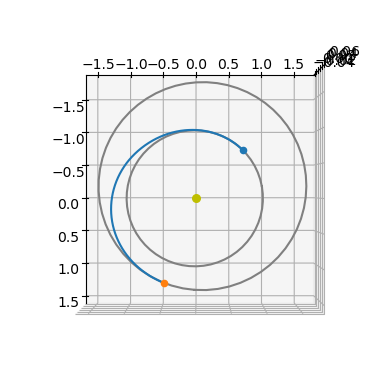

In [51]:
ax3D = prob.extract(pk.trajopt.pontryagin_cartesian_time).plot_trajectory(pop.champion_x, N=2000)
ax3D.view_init(90, 0)

The throttle is always on as indicated by the red color of the trajectory.

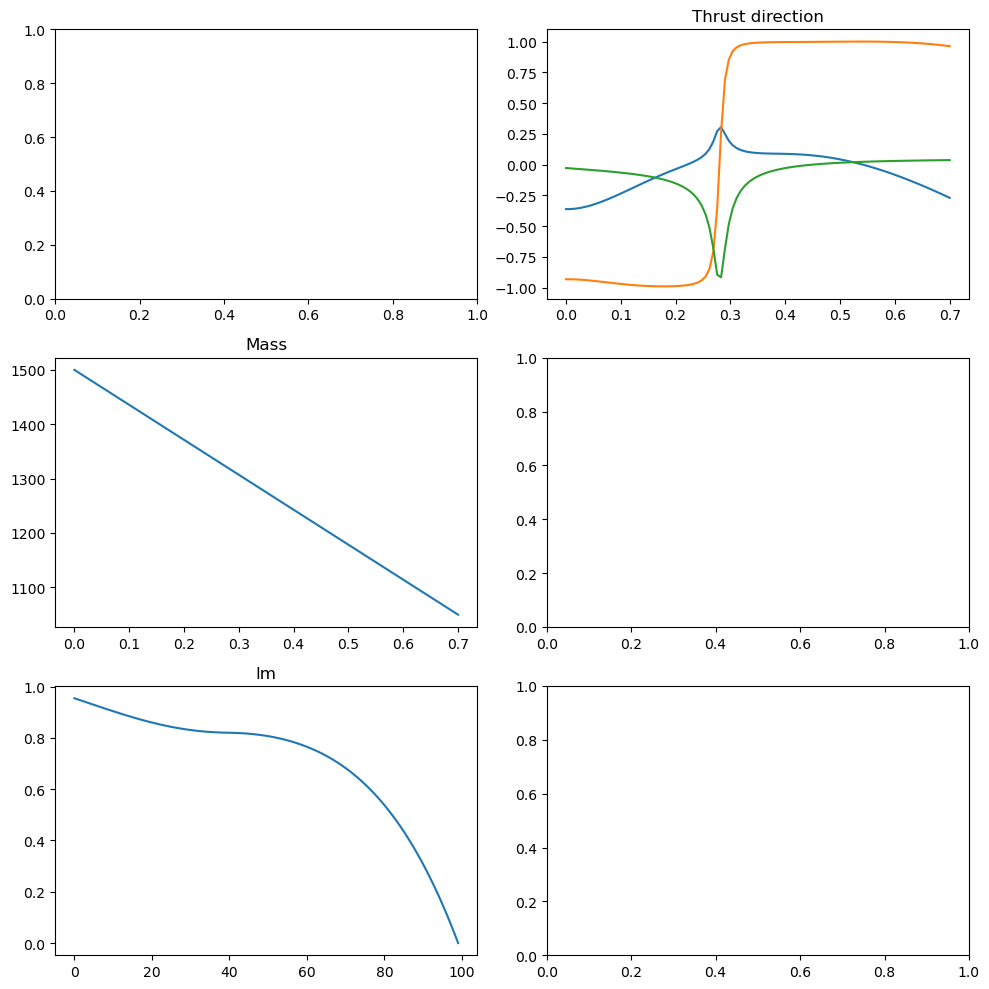

In [16]:
udp.plot_misc(pop.champion_x);

## Homotopy

We now try to use a continuation techniaue on the maximal thrust as to increase the number of revolutions and go towards a very-low-thrust trajectory.

## Exponential homotopy on $T_{max}$
Here we decrease the $T_{max}$ parameter exponentially and use as predictor for the new decision vector corresponding to each successive new value of $T_{max}$, the previous decision vector. This method forces the step size on the epsilon exponential decrease to
small values. 

In [17]:
# We instantiate a new optimzation roblem (a pygmo UDP) with the new parameters:
udp = pk.trajopt.pontryagin_cartesian_time(
    source=pk.planet(pk.udpla.jpl_lp("earth")),
    target=pk.planet(pk.udpla.jpl_lp("mars")),
    tof_guess=300,
    t0 = pk.epoch(400),
    T_max=0.6,
    Isp=3000,
    m0=1500,
    L=pk.AU,
    TIME=pk.YEAR2DAY * pk.DAY2SEC,
    MASS=1500,
    with_gradient=True,
)
prob = pg.problem(udp)
prob.c_tol = 1e-6

The following code block implements an exponential homotopy over $\epsilon$.

In [18]:
import time
from copy import deepcopy
from IPython.display import clear_output

# No initial guess
first = True
T_max = 0.6
decrease_factor = 0.95
algo=snopt

# Solve
while True:
    # Set the current epsilon in the udp and construct a problem 
    # (a copy here will be made, so that the udp inside the prob object
    # is a different udp)
    udp.c1 = T_max / (udp.MASS * udp.ACC)
    udp.c2 = (T_max / udp.Isp / pk.G0) / udp.MASS * udp.TIME
    prob = pg.problem(udp)
    prob.c_tol = 1e-6

    # First time looks for a solution, then it continues it
    if first:
        # Creates a random ic population
        pop = pg.population(prob, 1)
        # Starts the time to profile the homotopy time only 
        # (i.e. we exclude the effort to find the first valid traj)
        tstart_tot = time.time()
    else:
        # Use predicted new chromosome
        pop = pg.population(prob)
        pop.push_back(predicted_chromosome)

    # Evolve
    tstart = time.time()
    pop = algo.evolve(pop)
    tend = time.time()
    
    if first:
        algo=ipopt

    # Compute constraint violation norm
    err = np.linalg.norm(pop.champion_f[1:])

    # If we find a feasible solution (either the first or a continued one, we log and start the predictor)
    if prob.feasibility_f(pop.champion_f):
        first = False
        udp.tof_guess = pop.champion_x[-1]
        clear_output(wait=True)
        udp.fitness(pop.champion_x)
        print(
            f". Success!! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | T_max = {T_max:.4e} | Tof = {pop.champion_x[-1]*udp.TIME*pk.SEC2DAY:4e} | mass = {udp.ta.state[6]*udp.MASS:.4}"
        )

        # Save decision vector for current epsilon (which will be used as an initial guess in the next iteration)
        predicted_chromosome = deepcopy(pop.champion_x)
        best_T_max = T_max

        # Save current epsilon (needed if iteration fails)
        T_max_previous = T_max

        # Decrease epsilon
        T_max = T_max * decrease_factor

        # Stopping condition (desired epsilon reached)
        if T_max < 0.2:
            udp.fitness(pop.champion_x)
            print(
                f". Success!! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | T_max = {T_max:.4e} | Tof = {pop.champion_x[-1]*udp.TIME*pk.SEC2DAY:4e} | mass = {udp.ta.state[6]*udp.MASS:.4}"
            )
            break

    else:
        clear_output(wait=True)
        udp.fitness(pop.champion_x)
        print(
            f"x Failedd!! | Error: {err:.2e} | CPU time: {tend-tstart:.2e} | T_max = {T_max:.4e} | Tof = {pop.champion_x[-1]*udp.TIME*pk.SEC2DAY:4e} | mass = {udp.ta.state[6]*udp.MASS:.4}"
        )

        # If first iteration fails, try again with different initial guess
        if first:
            pass

        # T_max is too small, we need to increase it (halfway between previous and current)
        else:
            T_max = T_max + abs(T_max_previous - T_max) / 2
tend_tot = time.time()
print(f"Total CPU time: {tend_tot - tstart_tot:.2e}")

. Success!! | Error: 8.61e-11 | CPU time: 1.14e-01 | T_max = 2.0192e-01 | Tof = 9.375351e+02 | mass = 944.1
. Success!! | Error: 8.61e-11 | CPU time: 1.14e-01 | T_max = 1.9182e-01 | Tof = 9.375351e+02 | mass = 944.1
Total CPU time: 2.97e+00


In [20]:
udp.fitness(pop.champion_x)
print("mass", udp.ta.state[6]*udp.MASS)
print("time", pop.champion_x[-1]*udp.TIME*pk.SEC2DAY)


mass 944.058550456914
time 937.5351323587548


We could obtain a better total computational time if we could just use a higher exponential decrease factor ... but we cannot as 
the initial guess (the predictor used) is poor, so that we are stuck with this.

Let us plot what we found ...

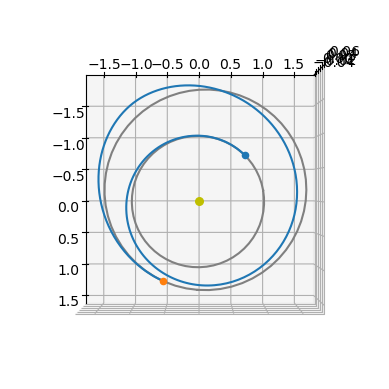

In [21]:
ax3D = udp.plot_trajectory(pop.champion_x, N=300)
ax3D.view_init(90, 0)

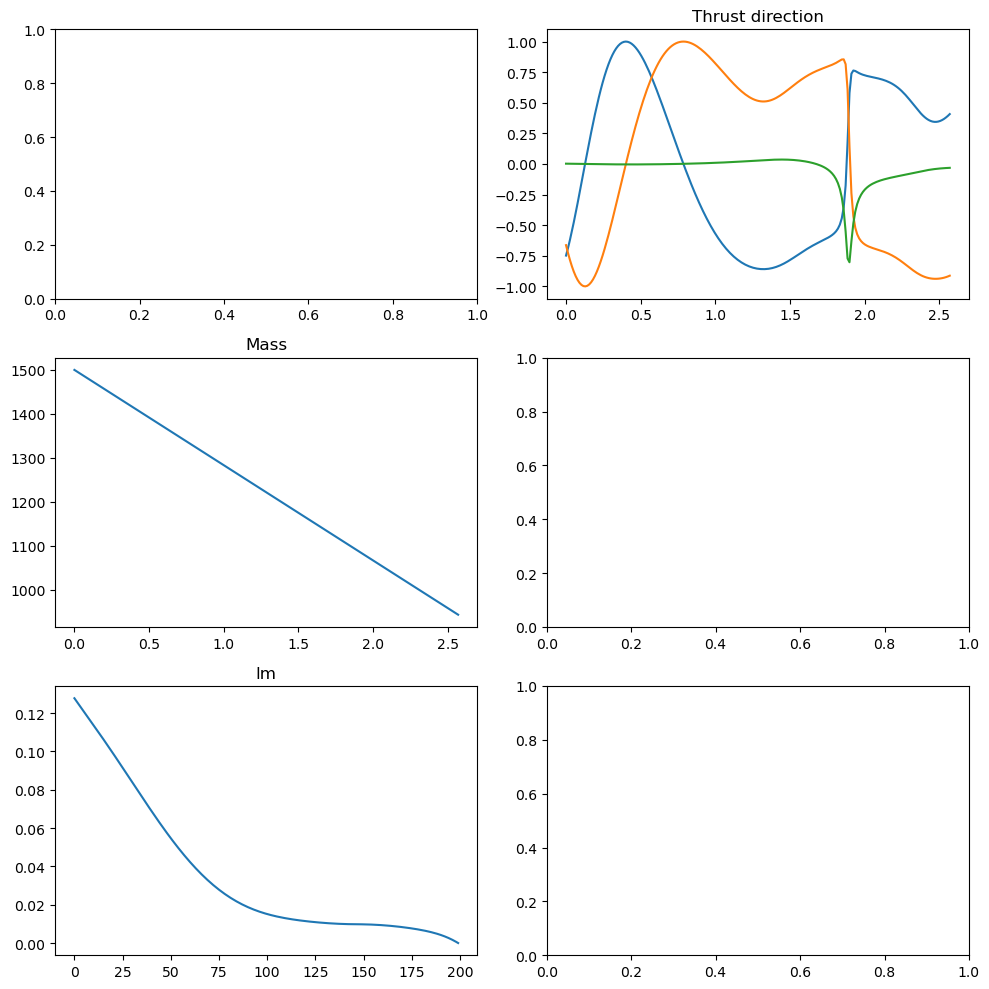

In [20]:
udp.plot_misc(pop.champion_x, N=200);